In [1]:
from trajectree.fock_optics.utils import create_vacuum_state
from trajectree.fock_optics.light_sources import light_source
from trajectree.fock_optics.devices import ry, rx, rz
from trajectree.fock_optics.measurement import create_threshold_POVM_OP_Dense, rotate_and_measure, create_PNR_POVM_OP_Dense
from trajectree.fock_optics.outputs import print_quantum_state, read_quantum_state
from trajectree.fock_optics.noise_models import single_mode_bosonic_noise_channels, depolarizing_operators, two_qubit_depolarizing_channel

from trajectree.trajectory import trajectory_evaluator, quantum_channel

import numpy as np
from scipy import sparse as sp
import qutip as qt
from numpy import sqrt
import time
import copy
from quimb.tensor.tensor_arbgeom import tensor_network_apply_op_vec #type: ignore
from quimb.tensor import MatrixProductOperator as mpo #type: ignore

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

/home/asingal/home/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/asingal/home/.venv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [2]:
def create_perfect_bell_state(N=3, error_tolerance = 1e-10):
    # Defining the control and target inputs here
    a_dag = qt.create(N).full()
    I = qt.identity(N).full()

    a_H = np.kron(a_dag, I)
    a_V = np.kron(I, a_dag)

    # Testing the case with only one MPS for both control and target
    vacuum = create_vacuum_state(num_modes=4, N=N)
    pure_EPPS_operator = 1/sqrt(2) * (np.kron(a_H, a_H) + np.kron(a_V, a_V))
    pure_EPPS_operator_MPO = mpo.from_dense(pure_EPPS_operator, dims = N, sites = (0,1,2,3), L=4, tags="ideal_state")    
    psi = tensor_network_apply_op_vec(pure_EPPS_operator_MPO, vacuum, compress=True, contract = True, cutoff = error_tolerance)
    return psi

First, we define some constants and matrices used in the scipt that don't change.  

In [11]:
def create_POVMs(efficiency, N, PNR = False):
    if not PNR:
        POVM_0 = create_threshold_POVM_OP_Dense(efficiency, 0, N)
        POVM_1 = create_threshold_POVM_OP_Dense(efficiency, 1, N)
    else:
        POVM_0 = create_PNR_POVM_OP_Dense(efficiency, 0, N, debug = False)
        POVM_1 = create_PNR_POVM_OP_Dense(efficiency, 1, N, debug = False)

    POVM_H = sp.csr_matrix( np.kron(POVM_1, POVM_0) ) # H detector clicks, V does not
    POVM_V = sp.csr_matrix( np.kron(POVM_0, POVM_1) ) # V detector clicks, H does not
    POVM_N = sp.csr_matrix( np.kron(POVM_0, POVM_0) ) # No detector clicks (Not used yet)
    POVM_B = sp.csr_matrix( np.kron(POVM_1, POVM_1) ) # Both detectors click (Not used yet)    

    return POVM_H, POVM_V, POVM_N, POVM_B

def calc_CHSH_measurements(POVM_H, POVM_V, POVM_N, POVM_B, dm):
    E = []
    for POVM_a in [POVM_H, POVM_V, POVM_N, POVM_B]:
        for POVM_b in [POVM_H, POVM_V, POVM_N, POVM_B]:
            E.append( (sp.kron(POVM_a, POVM_b) @ dm).trace().real )
    return E


def calc_CHSH_value(dm, efficiency, N, PNR = False):

    # First, we define some constants that we will be using for the experiment. 
    I = np.eye(N**2)
    ry_pi_4 = ry(np.pi/4, N, return_unitary=True)
    ry_pi_2 = ry(np.pi/2, N, return_unitary=True)

    op_00 = sp.csr_matrix( np.kron(I, ry_pi_4) @ np.kron(ry_pi_2, I) )
    op_01 = sp.csr_matrix( np.kron(I, ry_pi_4) @ np.kron(ry_pi_2, ry_pi_2) )
    op_10 = sp.csr_matrix( np.kron(I, ry_pi_4) @ np.kron(I, I) )
    op_11 = sp.csr_matrix( np.kron(I, ry_pi_4) @ np.kron(I, ry_pi_2) )

    measurements = [ 1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1,  1, -1,  1,  1]
                 # [HH, HV, HN, HB, VH, VV, VN, VB, NH, NV, NN, NB, BH, BV, BN, BB]
    mask = [measurements, measurements, measurements, [-x for x in measurements]] 
    
    POVM_H, POVM_V, POVM_N, POVM_B = create_POVMs(efficiency, N, PNR)

    dm_00 = op_00 @ dm @ op_00.conj().T
    E_00 = calc_CHSH_measurements(POVM_H, POVM_V, POVM_N, POVM_B, dm_00)
        
    dm_01 = op_01 @ dm @ op_01.conj().T
    E_01 = calc_CHSH_measurements(POVM_H, POVM_V, POVM_N, POVM_B, dm_01)

    dm_10 = op_10 @ dm @ op_10.conj().T
    E_10 = calc_CHSH_measurements(POVM_H, POVM_V, POVM_N, POVM_B, dm_10)

    dm_11 = op_11 @ dm @ op_11.conj().T
    E_11 = calc_CHSH_measurements(POVM_H, POVM_V, POVM_N, POVM_B, dm_11)

    return np.sum(np.multiply([E_00, E_01, E_10, E_11], mask)).real

    ############ Previous method of calculating CHSH value
    # CHSH_value = (E_00_00 - E_00_01 - E_00_10 + E_00_11) + (E_01_00 - E_01_01 - E_01_10 + E_01_11) + (E_10_00 - E_10_01 - E_10_10 + E_10_11) - (E_11_00 - E_11_01 - E_11_10 + E_11_11)
    # CHSH_values.append(CHSH_value)



    # expectation_matrix = [np.array([E_00_00, E_00_01, E_00_10, E_00_11])/sum([E_00_00, E_00_01, E_00_10, E_00_11]),
    #                       np.array([E_01_00, E_01_01, E_01_10, E_01_11])/sum([E_01_00, E_01_01, E_01_10, E_01_11]),
    #                       np.array([E_10_00, E_10_01, E_10_10, E_10_11])/sum([E_10_00, E_10_01, E_10_10, E_10_11]),
    #                       np.array([E_11_00, E_11_01, E_11_10, E_11_11])/sum([E_11_00, E_11_01, E_11_10, E_11_11])]
    
    # print(np.sum(np.multiply(expectation_matrix, mask), axis = 1))


In this notebook, we check if entangelement distribution with depolarizing error produces the same results as that from matrix calculations. 

In [3]:
def perform_simulation(N, num_simulations, quantum_channels, error_tolerance = 1e-10, track_dm = False):

    # num_modes = 8
    # vacuum = create_vacuum_state(num_modes=num_modes, N=N)
    # psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
    
    psi = create_perfect_bell_state(N, error_tolerance)

    t_eval = trajectory_evaluator(quantum_channels)

    probabilities = []
    dm = 0

    for i in range(num_simulations): 
        start = time.time()
        psi_iter = copy.deepcopy(t_eval.perform_simulation(psi, error_tolerance, normalize = False))
        probabilities.append(psi_iter.normalize())
        if track_dm:
            dm += psi_iter.to_dense() @ psi_iter.to_dense().conj().T
        time_taken = time.time() - start

    if track_dm: 
        dm = dm/num_simulations
        return probabilities, dm

    return probabilities

In [4]:
# params
trunc = 1
N = trunc+1
error_tolerance = 1e-12

In this section, we recreate the density matrix for a depolaried channel using three mwthods: direct calculation, explicit density matrix reconstruction in trajectree and querying the trajectree multiple times and summing up the contributions from the queried quantum states. 

First, we define the noise model that we will be testing and the initial state used for all three methods for recreating the density matrix. 

In [5]:
# Checking if the DMs match with what trajectree gives.
depolarizing_kraus_ops = two_qubit_depolarizing_channel(depolarizing_probability = 0.5, N = N)

vacuum = create_vacuum_state(num_modes=8, N=N)
psi = create_perfect_bell_state(N, error_tolerance = 1e-10)

First, we find the density matrix explicitly using matrix multiplication. 

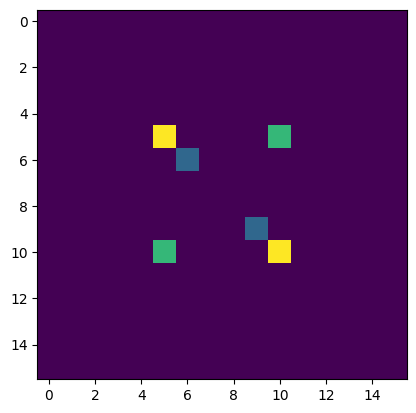

In [6]:
dm = psi.to_dense() @ psi.to_dense().conj().T
# print(len(dm))
direct_dm = 0
for i in depolarizing_kraus_ops:
    direct_dm += i @ dm @ i.conj().T
plt.figure()
plt.imshow(np.round(np.real(direct_dm), 15))



Now, we use trajectree's in-built density matrix calculation method and compare the result with the explicit DM calculated the previous cell:

<Compressed Sparse Row sparse array of dtype 'complex128'
	with 6 stored elements and shape (16, 16)>
  Coords	Values
  (5, 5)	(3.625+0j)
  (5, 10)	(-0.25+0j)
  (6, 6)	(3.875+0j)
  (9, 9)	(3.875+0j)
  (10, 5)	(-0.25-0j)
  (10, 10)	(3.625+0j)


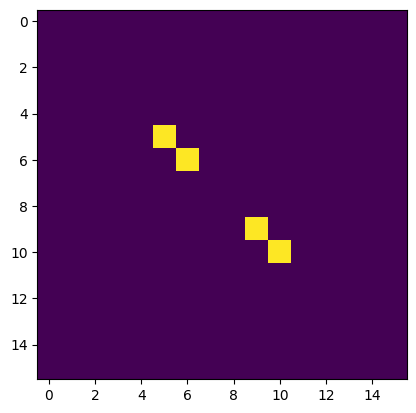

In [7]:
quantum_channel_list = []
quantum_channel_list.append(quantum_channel(N = N, num_modes = 8, formalism = "kraus", kraus_ops_tuple = ((0,1,2,3), depolarizing_kraus_ops), name = "depolarization")) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.

# Trajectree dm
t_eval = trajectory_evaluator(quantum_channel_list)
trajectree_dm = t_eval.calculate_density_matrix(psi, error_tolerance)

plt.figure()
# print(np.real(np.round(dm, 3)))
plt.imshow(np.real(np.round(trajectree_dm, 10)))


sp.csr_array(trajectree_dm - direct_dm)
print(sp.csr_array(np.round(trajectree_dm - direct_dm, 10)))


Now, we use trajectree to sample the trajectree using monte carlo simulations to recreate the density matrix and calculate the density matrices. 

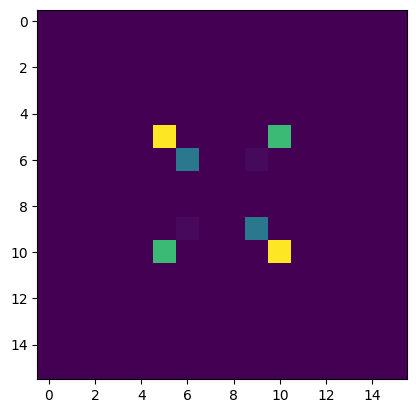

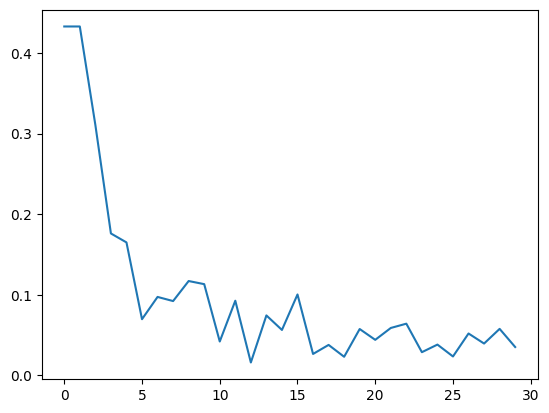

In [8]:
# Estimating the dm using trajectree
num_simulations = 300
 
fig, ax = plt.subplots()
ims = []
errors = []
estimated_dm = create_perfect_bell_state(N, error_tolerance).to_dense() @ create_perfect_bell_state(N, error_tolerance).to_dense().conj().T
for i in range(1, num_simulations, 10):
    errors.append(np.linalg.norm(estimated_dm - direct_dm))
    im = ax.imshow(np.real(estimated_dm), animated=True)
    ims.append([im])

    probs, estimated_dm = perform_simulation(N, i, quantum_channel_list, track_dm = True)

plt.figure()
plt.plot(errors)

ani = animation.ArtistAnimation(fig, ims)
display(HTML(ani.to_jshtml()))
ax.imshow(np.real(estimated_dm))

### We have verified the trajectree simulations!

Now, to validate the results from trajectree further, we will recreate the full CHSH experiment using full density matrices. 

In [9]:
efficiency = 1

num_simulations = 100
alice_angles = [np.pi/2, 0]
bob_angles = [np.pi/4, 3*np.pi/4]

depolarization_probabilities = np.linspace(0, 1, 10, endpoint=False) # np.linspace(0, 1, 2, endpoint=False) # np.linspace(0, 1, 30, endpoint=False)

Now, we know that optics should also produce the same result that the qubit version produces. So, we now first check if the density matrix from trajectree produces a similar result or not:

In [10]:
depolarization_rate_list = np.linspace(0, 1, 10)
CHSH_values = []

for depolarization_rate in depolarization_rate_list:
    quantum_channel_list = []
    depolarizing_kraus_ops = two_qubit_depolarizing_channel(depolarizing_probability = depolarization_rate, N = N)
    quantum_channel_list.append(quantum_channel(N = N, num_modes = 8, formalism = "kraus", kraus_ops_tuple = ((0,1,2,3), depolarizing_kraus_ops), name = "depolarization")) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.

    probs, direct_dm = perform_simulation(N, 500, quantum_channel_list, track_dm = True)

    CHSH_values.append(calc_CHSH_value(direct_dm, efficiency, N, PNR = False))

plt.plot(CHSH_values)
CHSH_values

/home/asingal/home/quimb/quimb/tensor/tensor_core.py:4459: RuntimeWarning: divide by zero encountered in scalar power
  return self.multiply_(other**-1)
/home/asingal/home/quimb/quimb/tensor/tensor_core.py:4388: RuntimeWarning: invalid value encountered in scalar divide
  x_sign = x / x_abs
/home/asingal/home/quimb/quimb/tensor/tensor_core.py:4400: RuntimeWarning: invalid value encountered in multiply
  tensor.modify(apply=lambda data: data * x_spread)


NameError: name 'calc_CHSH_value' is not defined

In [1]:
from trajectree.fock_optics.utils import create_vacuum_state
from trajectree.fock_optics.light_sources import light_source
from trajectree.fock_optics.devices import ry, rx, rz
from trajectree.fock_optics.measurement import create_threshold_POVM_OP_Dense, rotate_and_measure, create_PNR_POVM_OP_Dense
from trajectree.fock_optics.outputs import print_quantum_state, read_quantum_state
from trajectree.fock_optics.noise_models import single_mode_bosonic_noise_channels, depolarizing_operators, two_qubit_depolarizing_channel

from trajectree.trajectory import trajectory_evaluator, quantum_channel

import numpy as np
from scipy import sparse as sp
import qutip as qt
from numpy import sqrt
from quimb.tensor.tensor_arbgeom import tensor_network_apply_op_vec #type: ignore
from quimb.tensor import MatrixProductOperator as mpo #type: ignore

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

/home/asingal/home/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/asingal/home/.venv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [2]:
def create_perfect_bell_state(N=3, error_tolerance = 1e-10):
    # Defining the control and target inputs here
    a_dag = qt.create(N).full()
    I = qt.identity(N).full()

    a_H = np.kron(a_dag, I)
    a_V = np.kron(I, a_dag)

    # Testing the case with only one MPS for both control and target
    vacuum = create_vacuum_state(num_modes=4, N=N)
    pure_EPPS_operator = 1/sqrt(2) * (np.kron(a_H, a_H) + np.kron(a_V, a_V))
    pure_EPPS_operator_MPO = mpo.from_dense(pure_EPPS_operator, dims = N, sites = (0,1,2,3), L=4, tags="ideal_state")    
    psi = tensor_network_apply_op_vec(pure_EPPS_operator_MPO, vacuum, compress=True, contract = True, cutoff = error_tolerance)
    return psi

In [3]:
def perform_simulation(N, num_simulations, quantum_channels, error_tolerance = 1e-10, track_dm = False):

    # psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
    psi = create_perfect_bell_state(N, error_tolerance)

    t_eval = trajectory_evaluator(quantum_channels)

    probabilities = []
    dm = 0

    for i in range(num_simulations): 
        # start = time.time()
        psi_iter = copy.deepcopy(t_eval.perform_simulation(psi, error_tolerance, normalize = False))
        probabilities.append(psi_iter.normalize())
        # time_taken = time.time() - start

    return probabilities

In [ ]:
# params
trunc = 1
N = trunc+1
error_tolerance = 1e-12

mean_photon_num = (0.26)
efficiency = 1

num_simulations = 100
alice_angles = [np.pi/2, 0]
bob_angles = [np.pi/4, 3*np.pi/4]

depolarization_probabilities = np.linspace(0, 1, 10, endpoint=False) # np.linspace(0, 1, 2, endpoint=False) # np.linspace(0, 1, 30, endpoint=False)